In [1]:
import os
import sys
import pickle
# import rpy2.robjects as robjects
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import scipy.sparse as sp
from torchvision import transforms as tfs
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
from torch_geometric.nn import HGTConv, Linear
# from torch_geometric.loader import HGTLoader
from torch.cuda.amp import autocast
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score
from torchsummary import summary
import random
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, average_precision_score
from torch.utils.data import WeightedRandomSampler
import math
from einops import rearrange, reduce
from einops.layers.torch import Rearrange
from Bio import pairwise2
from torch.nn.parameter import Parameter


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


set_seed(2022)
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

In [2]:
def get_acc_p_r_f1(trues, preds):
    labels = [1]
    TP,FP,FN,TN = 0,0,0,0
    for label in labels:
        preds_tmp = np.array([1 if pred == label else 0 for pred in preds])
        trues_tmp = np.array([1 if true == label else 0 for true in trues])
        # print(preds_tmp, trues_tmp)
        # print()
        # TP预测为1真实为1
        # TN预测为0真实为0
        # FN预测为0真实为1
        # FP预测为1真实为0
        TP += ((preds_tmp == 1) & (trues_tmp == 1)).sum()
        TN += ((preds_tmp == 0) & (trues_tmp == 0)).sum()
        FN += ((preds_tmp == 0) & (trues_tmp == 1)).sum()
        FP += ((preds_tmp == 1) & (trues_tmp == 0)).sum()
    print(TP, FP, FN,TN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)
    accuracy=(TP + TN)/(TP + TN + FP + FN)
    specificity = TN / (TN + FP) 
    npre=TN / (TN + FN)
    fpr=FP/(TN + FP)
    fnr=FN/(TP + FN)
    
    return precision, recall, f1,accuracy,fpr,specificity,npre,fnr

In [3]:
with open('HGT6_result_1.pkl','rb') as f:  # Python 3: open(..., 'rb')
        tp_hgt,fp_hgt,tn_hgt,fn_hgt,rel_hgt,pre_hgt = pickle.load(f)

In [4]:
with open('HerMLP_result.pkl','rb') as f:  # Python 3: open(..., 'rb')
        tp_her,fp_her,tn_her,fn_her,rel_her,pre_her = pickle.load(f)

In [5]:
with open('TranCNN13_resultcpu_1.pkl','rb') as f:  # Python 3: open(..., 'rb')
        tp_cnn,fp_cnn,tn_cnn,fn_cnn,rel_cnn,pre_cnn = pickle.load(f)

In [6]:
with open('RGCN_BiLSTM_result.pkl','rb') as f:  # Python 3: open(..., 'rb')
        tp_rb,fp_rb,tn_rb,fn_rb,rel_rb,pre_rb = pickle.load(f)

In [7]:
with open('RGCN_result.pkl','rb') as f:  # Python 3: open(..., 'rb')
        tp_r,fp_r,tn_r,fn_r,rel_r,pre_r = pickle.load(f)

In [8]:
with open('HGT_BiLSTM_result.pkl','rb') as f:  # Python 3: open(..., 'rb')
        tp_hb,fp_hb,tn_hb,fn_hb,rel_hb,pre_hb = pickle.load(f)

In [9]:
fpr1, tpr1, thresholds = roc_curve(rel_hgt,pre_hgt, pos_label=1)
auc_value1=auc(fpr1,tpr1)
precision1, recall1, _ = precision_recall_curve(rel_hgt,pre_hgt,pos_label=1)
aupr1 = average_precision_score(rel_hgt,pre_hgt,pos_label=1)
print(auc_value1,aupr1)

0.8548733944788773 0.7670934723617726


In [10]:
fpr2, tpr2, thresholds = roc_curve(rel_her,pre_her, pos_label=1)
auc_value2=auc(fpr2,tpr2)
precision2, recall2, _ = precision_recall_curve(rel_her,pre_her,pos_label=1)
aupr2 = average_precision_score(rel_her,pre_her,pos_label=1)
print(auc_value2,aupr2)

0.8705548759102928 0.8108665734192012


In [11]:
fpr3, tpr3, thresholds = roc_curve(rel_cnn,pre_cnn, pos_label=1)
auc_value3=auc(fpr3,tpr3)
precision3, recall3, _ = precision_recall_curve(rel_cnn,pre_cnn,pos_label=1)
aupr3 = average_precision_score(rel_cnn,pre_cnn,pos_label=1)
print(auc_value3,aupr3)

0.8678388482228215 0.8072353138210113


In [12]:
fpr4, tpr4, thresholds = roc_curve(rel_rb,pre_rb, pos_label=1)
auc_value4=auc(fpr4,tpr4)
precision4, recall4, _ = precision_recall_curve(rel_rb,pre_rb,pos_label=1)
aupr4 = average_precision_score(rel_rb,pre_rb,pos_label=1)
print(auc_value4,aupr4)

0.841181846787681 0.7754288887438799


In [13]:
fpr5, tpr5, thresholds = roc_curve(rel_r,pre_r, pos_label=1)
auc_value5=auc(fpr5,tpr5)
precision5, recall5, _ = precision_recall_curve(rel_r,pre_r,pos_label=1)
aupr5 = average_precision_score(rel_r,pre_r,pos_label=1)
print(auc_value5,aupr5)

0.6666063246811863 0.46586250342664554


In [14]:
fpr6, tpr6, thresholds = roc_curve(rel_hb,pre_hb, pos_label=1)
auc_value6=auc(fpr6,tpr6)
precision6, recall6, _ = precision_recall_curve(rel_hb,pre_hb,pos_label=1)
aupr6 = average_precision_score(rel_hb,pre_hb,pos_label=1)
print(auc_value6,aupr6)

0.8366966761967201 0.7399943690790847


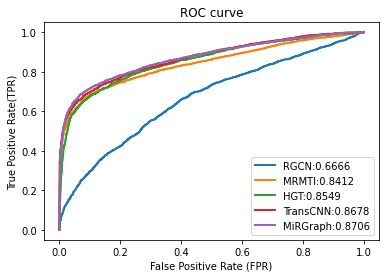

In [16]:
plt.figure()
plt.step(fpr5, tpr5,linewidth=2,label='RGCN:{0:.4f}'.format(auc_value5))
plt.step(fpr4, tpr4,linewidth=2,label='MRMTI:{0:.4f}'.format(auc_value4))
#plt.step(fpr6, tpr6,linewidth=2,label='HGT_BiLSTM:{0:.4f})'.format(auc_value6))
plt.step(fpr1, tpr1,linewidth=2,label='HGT:{0:.4f}'.format(auc_value1))
plt.step(fpr3, tpr3,linewidth=2,label='TransCNN:{0:.4f}'.format(auc_value3))
plt.step(fpr2, tpr2,linewidth=2,label='MiRGraph:{0:.4f}'.format(auc_value2))
#plt.plot([0, 0], [1, 1], color='navy',linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate(TPR)' )
plt.title('ROC curve')
plt.legend(loc=4)
plt.savefig('./ROC_1.jpg')

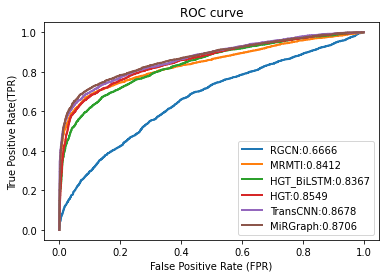

In [18]:
plt.figure()
plt.step(fpr5, tpr5,linewidth=2,label='RGCN:{0:.4f}'.format(auc_value5))
#plt.step(fpr6, tpr6,linewidth=2,label='HGT_BiLSTM:{0:.4f}'.format(auc_value6))
plt.step(fpr4, tpr4,linewidth=2,label='MRMTI:{0:.4f}'.format(auc_value4))
plt.step(fpr6, tpr6,linewidth=2,label='HGT_BiLSTM:{0:.4f}'.format(auc_value6))
plt.step(fpr1, tpr1,linewidth=2,label='HGT:{0:.4f}'.format(auc_value1))
plt.step(fpr3, tpr3,linewidth=2,label='TransCNN:{0:.4f}'.format(auc_value3))
plt.step(fpr2, tpr2,linewidth=2,label='MiRGraph:{0:.4f}'.format(auc_value2))
#plt.plot([0, 0], [1, 1], color='navy',linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate(TPR)' )
plt.title('ROC curve')
plt.legend(loc=4)
#plt.savefig('./ROC_6_1.jpg')
plt.savefig('ROC_6.pdf', bbox_inches='tight')

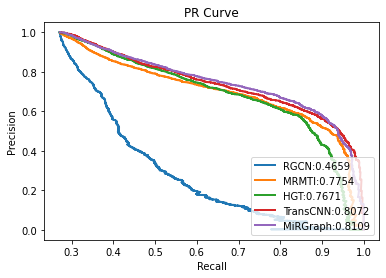

In [17]:
plt.figure()
plt.step(precision5, recall5,linewidth=2,label='RGCN:{0:.4f}'.format(aupr5))
plt.step(precision4, recall4,linewidth=2,label='MRMTI:{0:.4f}'.format(aupr4))
plt.step(precision1, recall1,linewidth=2,label='HGT:{0:.4f}'.format(aupr1))
#plt.step(fpr2, tpr2,color='navy',linewidth=2,label='HerGraph:{0:.4f})'.format(auc_value2))
plt.step(precision3, recall3,linewidth=2,label='TransCNN:{0:.4f}'.format(aupr3))
plt.step(precision2, recall2,linewidth=2,label='MiRGraph:{0:.4f}'.format(aupr2))
#plt.plot([0, 0], [1, 1], color='navy',linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve')
plt.legend(loc=4)
plt.savefig('PR_6.pdf', bbox_inches='tight')

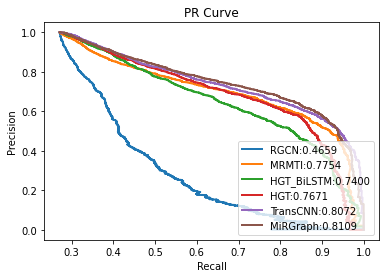

In [19]:
plt.figure()
plt.step(precision5, recall5,linewidth=2,label='RGCN:{0:.4f}'.format(aupr5))
#plt.step(precision6, recall6,linewidth=2,label='HGT_BiLSTM:{0:.4f})'.format(aupr6))
plt.step(precision4, recall4,linewidth=2,label='MRMTI:{0:.4f}'.format(aupr4))
plt.step(precision6, recall6,linewidth=2,label='HGT_BiLSTM:{0:.4f}'.format(aupr6))
plt.step(precision1, recall1,linewidth=2,label='HGT:{0:.4f}'.format(aupr1))
plt.step(precision3, recall3,linewidth=2,label='TransCNN:{0:.4f}'.format(aupr3))
plt.step(precision2, recall2,linewidth=2,label='MiRGraph:{0:.4f}'.format(aupr2))
#plt.plot([0, 0], [1, 1], color='navy',linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve')
plt.legend(loc=4)
plt.savefig('PR_6.pdf', bbox_inches='tight')

In [21]:
s1 = pre_hgt
s1[s1 > 0.5] = 1
s1[s1 <= 0.5] = 0
precision, recall, f1,accuracy,fpr,specificity,npre,fnr=get_acc_p_r_f1(rel_hgt,pre_hgt)
print(precision, recall, f1,accuracy,fpr,specificity,npre,fnr)

1546 745 677 5245
0.674814491488433 0.6954565901934323 0.6849800620292423 0.8268598563253379 0.12437395659432388 0.8756260434056762 0.8856805133400878 0.3045434098065677


In [22]:
s1 = pre_her
s1[s1 > 0.5] = 1
s1[s1 <= 0.5] = 0
precision, recall, f1,accuracy,fpr,specificity,npre,fnr=get_acc_p_r_f1(rel_her,pre_her)
print(precision, recall, f1,accuracy,fpr,specificity,npre,fnr)

1508 392 715 5598
0.7936842105263158 0.6783625730994152 0.7315061848168809 0.8652136856203579 0.06544240400667779 0.9345575959933222 0.8867416442261999 0.3216374269005848


In [23]:
s1 = pre_cnn
s1[s1 > 0.5] = 1
s1[s1 <= 0.5] = 0
precision, recall, f1,accuracy,fpr,specificity,npre,fnr=get_acc_p_r_f1(rel_cnn,pre_cnn)
print(precision, recall, f1,accuracy,fpr,specificity,npre,fnr)

1605 772 618 5218
0.6752208666386201 0.7219973009446694 0.6978260869565218 0.830756118348959 0.128881469115192 0.8711185308848081 0.8941055517477724 0.27800269905533065


In [24]:
s1 = pre_rb
s1[s1 > 0.5] = 1
s1[s1 <= 0.5] = 0
precision, recall, f1,accuracy,fpr,specificity,npre,fnr=get_acc_p_r_f1(rel_rb,pre_rb)
print(precision, recall, f1,accuracy,fpr,specificity,npre,fnr)

1493 542 730 5448
0.7336609336609337 0.6716149347728295 0.701268201033349 0.8451235845610617 0.09048414023372287 0.9095158597662771 0.881838782777598 0.3283850652271705


In [25]:
s1 = pre_r
s1[s1 > 0.5] = 1
s1[s1 <= 0.5] = 0
precision, recall, f1,accuracy,fpr,specificity,npre,fnr=get_acc_p_r_f1(rel_r,pre_r)
print(precision, recall, f1,accuracy,fpr,specificity,npre,fnr)

867 983 1356 5007
0.46864864864864864 0.3900134952766532 0.42573041983795723 0.7152075977109461 0.16410684474123538 0.8358931552587646 0.7868929750117869 0.6099865047233468


In [26]:
s1 = pre_hb
s1[s1 > 0.5] = 1
s1[s1 <= 0.5] = 0
precision, recall, f1,accuracy,fpr,specificity,npre,fnr=get_acc_p_r_f1(rel_hb,pre_hb)
print(precision, recall, f1,accuracy,fpr,specificity,npre,fnr)

1474 820 749 5170
0.6425457715780296 0.663067926225821 0.6526455612131946 0.8089614026543285 0.13689482470784642 0.8631051752921536 0.8734583544517655 0.33693207377417905


In [ ]:
#### Case Study

In [1]:
# import os
# import sys
# import pickle
# # import rpy2.robjects as robjects
# import torch
# from torch.autograd import Variable
# import torch.nn.functional as F
# from torch import nn
# from torch.utils.data import Dataset, DataLoader, random_split
# import numpy as np
# import scipy.sparse as sp
# from torchvision import transforms as tfs
# from torch_geometric.data import HeteroData
# import torch_geometric.transforms as T
# from torch_geometric.nn import HGTConv, Linear
# # from torch_geometric.loader import HGTLoader
# from torch.cuda.amp import autocast
# from torch_geometric.utils import negative_sampling
# from sklearn.metrics import roc_auc_score
# from torchsummary import summary
# import random
# from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, average_precision_score
# from torch.utils.data import WeightedRandomSampler
# import math
# from einops import rearrange, reduce
# from einops.layers.torch import Rearrange
# from Bio import pairwise2
# from torch.nn.parameter import Parameter


# def set_seed(seed):
#     random.seed(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)


# set_seed(2022)
# import matplotlib.pyplot as plt
# from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, average_precision_score
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# with open('/lustre06/project/6050659/liupei89/Testcell/predictUnknownData_Score.pkl','rb') as f:  # Python 3: open(..., 'rb')
#         allunknown,pre,xm,xg = pickle.load(f)